In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## 📦 Load Data

In [2]:
# Load data
sme_df = pd.read_csv("/Users/carsell/iwoca-credit-compass-project/generated_data/sme_credit_profiles.csv")
event_df = pd.read_csv("/Users/carsell/iwoca-credit-compass-project/generated_data/product_engagement_log.csv")
score_df = pd.read_csv("/Users/carsell/iwoca-credit-compass-project/generated_data/monthly_credit_scores.csv")

## 🧩 SME Profile Exploration

In [19]:
# Shape and types
print("Shape:", sme_df.shape)
sme_df.info()
sme_df.describe()

# Categorical analysis
for col in ['sector', 'region', 'default_risk_category']:
    print(f"\n{col} value counts:")
    print(sme_df[col].value_counts())

Shape: (500, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   business_id            500 non-null    object 
 1   business_name          500 non-null    object 
 2   sector                 500 non-null    object 
 3   region                 500 non-null    object 
 4   employees              500 non-null    int64  
 5   annual_revenue (£)     500 non-null    float64
 6   credit_score           500 non-null    int64  
 7   created_at             500 non-null    object 
 8   default_risk_category  500 non-null    object 
 9   funding_needs          500 non-null    float64
 10  loan_history_score     500 non-null    float64
dtypes: float64(3), int64(2), object(6)
memory usage: 43.1+ KB

sector value counts:
sector
Technology       116
Services         109
Healthcare       101
Manufacturing     89
Retail            85
Name:

📊 Visuals

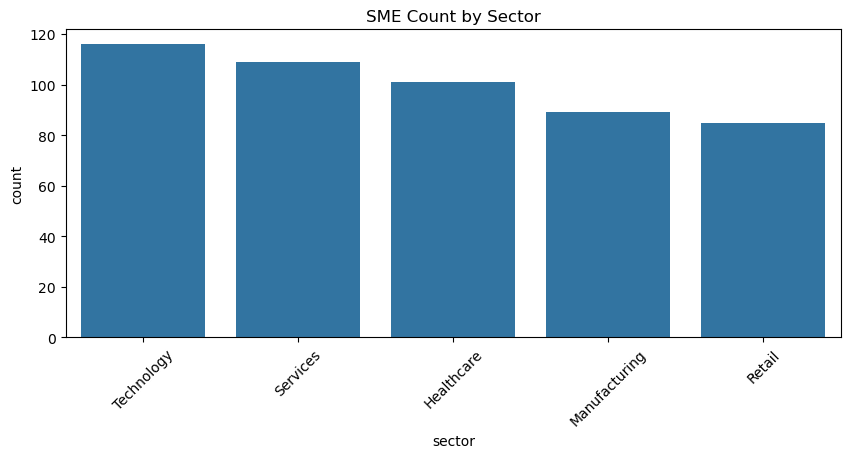

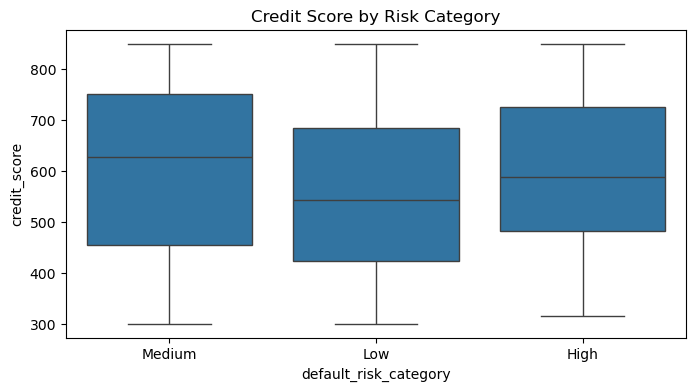

In [23]:
plt.figure(figsize=(10, 4))
sns.countplot(data=sme_df, x='sector', order=sme_df['sector'].value_counts().index)
plt.title('SME Count by Sector')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(data=sme_df, x='default_risk_category', y='credit_score')
plt.title('Credit Score by Risk Category')
plt.show()

# 🧪 Product Engagement Analysis

In [26]:
event_df['timestamp'] = pd.to_datetime(event_df['timestamp'])

# Top features used
print(event_df['feature_name'].value_counts())

# Add event_date
event_df['event_date'] = event_df['timestamp'].dt.date

# Conversion events
conversion_rate = event_df['is_conversion_event'].mean() * 100
print(f"Conversion rate: {conversion_rate:.2f}%")

# Engagement per business
engagement_counts = event_df.groupby('business_id')['event_type'].count().reset_index(name='engagement_count')

feature_name
growth_dashboard          12713
funding_recommendation    12533
credit_score_report       12382
cash_flow_forecast        12372
Name: count, dtype: int64
Conversion rate: 5.05%


# 📉 Monthly Credit Score Tracking

In [45]:
score_df = score_df.drop(columns=[
    'sector_x', 'sector_y',
    'region_x', 'region_y',
    'default_risk_category_x', 'default_risk_category_y',
    'created_at_x', 'created_at_y'
], errors='ignore')

Index(['business_id', 'month', 'credit_score', 'funding_granted (£)',
       'product_used', 'months_on_platform', 'sector', 'region',
       'default_risk_category', 'created_at'],
      dtype='object')


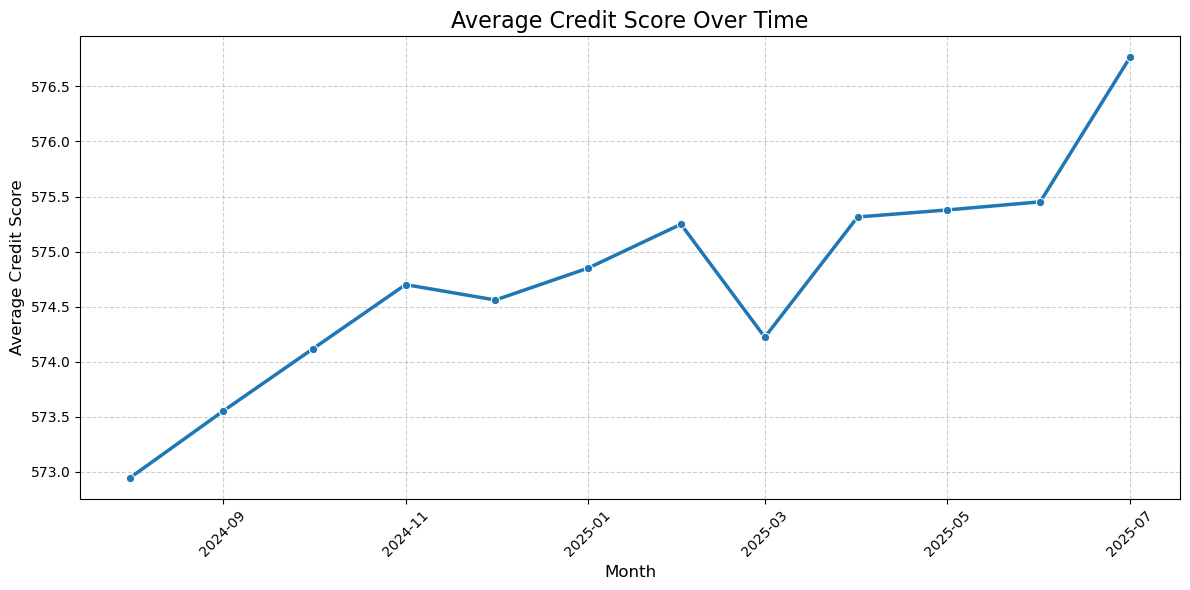

In [49]:
# Ensure month column is datetime
score_df['month'] = pd.to_datetime(score_df['month'], format="%Y-%m")

# Drop old columns if needed to avoid duplication (optional safety check)
if 'sector' in score_df.columns:
    score_df = score_df.drop(columns=['sector', 'region', 'default_risk_category', 'created_at'], errors='ignore')

# Merge in the SME attributes
score_df = score_df.merge(
    sme_df[['business_id', 'sector', 'region', 'default_risk_category', 'created_at']],
    on='business_id',
    how='left'
)

# Confirm created_at exists
print(score_df.columns)

# Convert created_at to datetime
score_df['created_at'] = pd.to_datetime(score_df['created_at'])

# Calculate months_on_platform
score_df['months_on_platform'] = (
    (score_df['month'].dt.year - score_df['created_at'].dt.year) * 12 +
    (score_df['month'].dt.month - score_df['created_at'].dt.month)
).clip(lower=0)

# Credit score trend
avg_scores = score_df.groupby('month')['credit_score'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_scores, x='month', y='credit_score', linewidth=2.5, marker='o')
plt.title("Average Credit Score Over Time", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Credit Score", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



# 🏗️ Feature Engineering

In [52]:
# Average funding per sector
sector_funding = score_df.groupby('sector')['funding_granted (£)'].mean().sort_values(ascending=False)
print("Average Funding by Sector:\n", sector_funding)

# Create churn flag: business not using product in last 3 months
recent_usage = score_df[score_df['product_used']].groupby('business_id')['month'].max().reset_index()
cutoff_date = score_df['month'].max() - pd.DateOffset(months=3)
recent_usage['is_churned'] = recent_usage['month'] < cutoff_date
score_df = score_df.merge(recent_usage[['business_id', 'is_churned']], on='business_id', how='left')
score_df['is_churned'] = score_df['is_churned'].fillna(True)


Average Funding by Sector:
 sector
Retail           3170.974108
Services         3037.510940
Healthcare       2841.322368
Manufacturing    2811.602500
Technology       2756.968865
Name: funding_granted (£), dtype: float64


# 🧾 Tableau-Ready Export

In [55]:
final_df = score_df.merge(engagement_counts, on='business_id', how='left')
final_df.to_csv("/Users/carsell/iwoca-credit-compass-project/data/credit_insight_tableau.csv", index=False)


OSError: Cannot save file into a non-existent directory: '/Users/carsell/iwoca-credit-compass-project/data'